### Using TwelveData Financial API

- https://twelvedata.com

In [1]:
# Load in API key from TwelveData
from secrets1 import key1

# Other imports
import requests
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
BASE_URL = "https://api.twelvedata.com/time_series"


In [3]:
# Selected 8 stock tickers
stock_symbols = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Google
    "TSLA",  # Tesla
    "META",  # Meta (Facebook)
    "AMZN",  # Amazon
    "DIS",  # Disney
    "PFE",  # Pfizer
]

In [4]:
# Define time range for training (simulation inputs)
start_date = "2020-03-01"
end_date = "2021-03-01"

In [5]:
# Dictionary to store fetched price data
price_data = {}

In [6]:
# Defining function to fetch stock data
def fetch_prices(symbol, start_date, end_date, api_key):
    params = {
        "symbol": symbol,
        "interval": "1day",
        "start_date": start_date,
        "end_date": end_date,
        "apikey": api_key,
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json() # turns into python dictionary to use

    if "values" not in data:
        print(
            f"❌ Failed to fetch data for {symbol}: {data.get('message', 'Unknown error')}"
        )
        return None

    df = pd.DataFrame(data["values"])
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["close"] = pd.to_numeric(df["close"])
    df = df.sort_values("datetime")
    return df[["datetime", "close"]]

In [7]:
# Fetch and store data for each stock
for symbol in stock_symbols:
    print(f"📦 Fetching data for {symbol}...")
    df = fetch_prices(symbol, start_date, end_date, key1)
    if df is not None:
        price_data[symbol] = df
        print(f"✅ {symbol} data loaded: {len(df)} rows")
    else:
        print(f"⚠️ Skipping {symbol} due to fetch error.")

📦 Fetching data for AAPL...
✅ AAPL data loaded: 251 rows
📦 Fetching data for MSFT...
✅ MSFT data loaded: 251 rows
📦 Fetching data for GOOGL...
✅ GOOGL data loaded: 251 rows
📦 Fetching data for TSLA...
✅ TSLA data loaded: 251 rows
📦 Fetching data for META...
✅ META data loaded: 251 rows
📦 Fetching data for AMZN...
✅ AMZN data loaded: 251 rows
📦 Fetching data for DIS...
✅ DIS data loaded: 251 rows
📦 Fetching data for PFE...
✅ PFE data loaded: 251 rows


In [9]:
type(price_data)              # should be a dict


dict

In [15]:
price_data["AAPL"].head()

datetime    close
250 2020-03-02  74.7025
249 2020-03-03  72.3300
248 2020-03-04  75.6850
247 2020-03-05  73.2300
246 2020-03-06  72.2575

In [18]:
price_data.keys() 

dict_keys(['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'META', 'AMZN', 'DIS', 'PFE'])

In [19]:
for symbol in price_data:
    print(symbol, price_data[symbol].shape)

AAPL (251, 2)
MSFT (251, 2)
GOOGL (251, 2)
TSLA (251, 2)
META (251, 2)
AMZN (251, 2)
DIS (251, 2)
PFE (251, 2)


In [20]:
for symbol in price_data:
    print(symbol, type(price_data[symbol]))

AAPL <class 'pandas.core.frame.DataFrame'>
MSFT <class 'pandas.core.frame.DataFrame'>
GOOGL <class 'pandas.core.frame.DataFrame'>
TSLA <class 'pandas.core.frame.DataFrame'>
META <class 'pandas.core.frame.DataFrame'>
AMZN <class 'pandas.core.frame.DataFrame'>
DIS <class 'pandas.core.frame.DataFrame'>
PFE <class 'pandas.core.frame.DataFrame'>


In [21]:
# Calculate daily returns
daily_returns = {}

for symbol in price_data:
    df = price_data[symbol]
    returns = df["close"].pct_change().dropna()
    daily_returns[symbol] = returns

In [22]:
volatility = {}
mean_returns = {}

for symbol, returns in daily_returns.items():
    volatility[symbol] = returns.std()
    mean_returns[symbol] = returns.mean()

In [24]:
# Checking APPL daily return standard deviation 'volatility' and average daily return
print(volatility['AAPL'])
print(mean_returns['AAPL'])

0.028775772510532364
0.002352630240316599


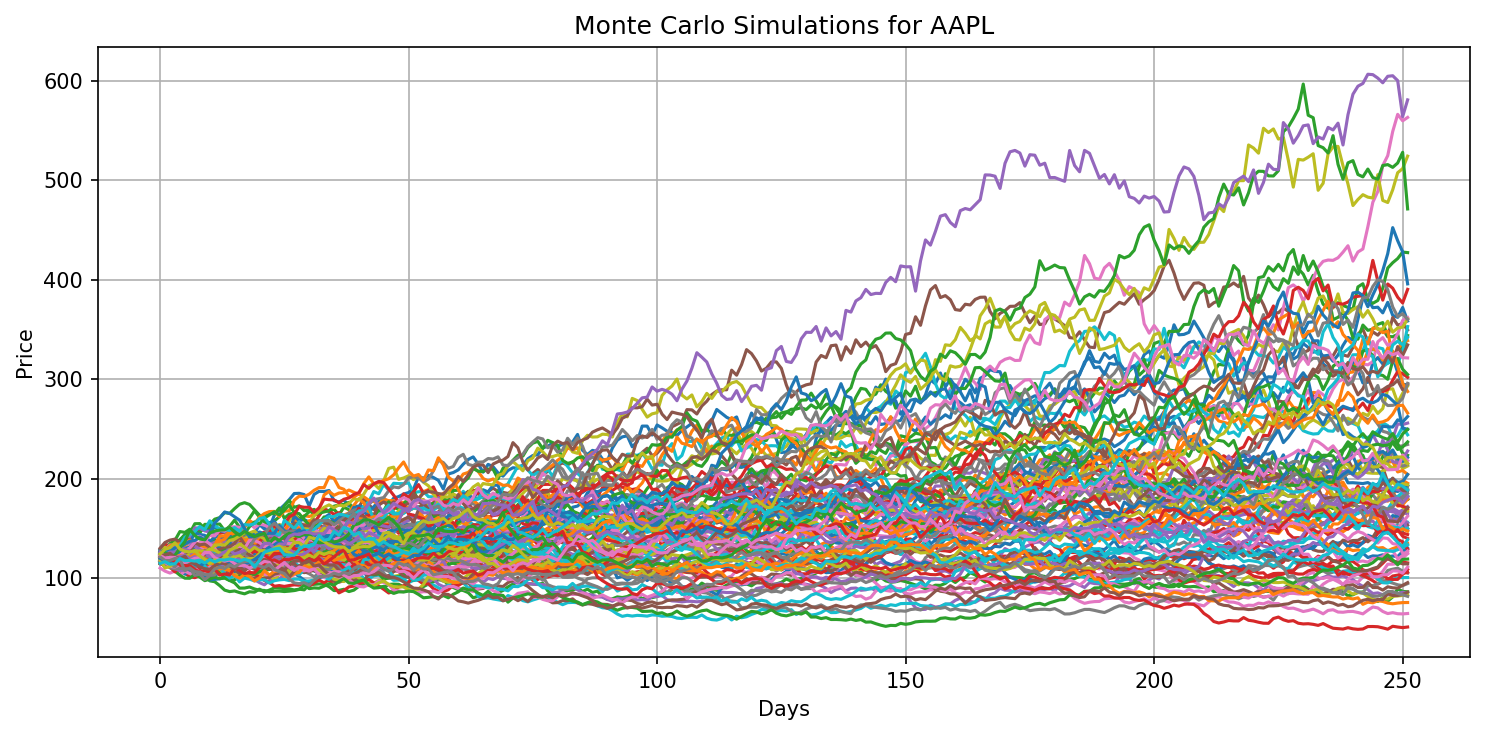

In [ ]:
# Apple future price path, after 1 year
simulations = 100
days = 252  # Approx. 1 year of trading days
last_price = price_data['AAPL']["close"].iloc[-1]
mu = mean_returns['AAPL']
sigma = volatility['AAPL']

paths = np.zeros((days, simulations))
for i in range(simulations):
    daily_returns = np.random.normal(mu, sigma, days)
    paths[:, i] = last_price * np.cumprod(1 + daily_returns)

plt.figure(figsize=(10, 5), dpi=150)  
plt.plot(paths)
plt.title("Monte Carlo Simulations for AAPL")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.savefig("aapl_simulation.png", dpi=150)  # save image
plt.show()

In [30]:
# Actual AAPL price on March 1, 2022 (end_date)
actual_df = fetch_prices("AAPL", "2022-02-28", "2022-03-02", key1)
print(actual_df)  # See what dates you actually get

    datetime   close
1 2022-02-28  165.12
0 2022-03-01  163.20


In [31]:
actual_price = actual_df.loc[actual_df["datetime"] == "2022-03-01", "close"].values[0]
print(f"📈 Actual AAPL price on 2022-03-01: ${actual_price:.2f}")

📈 Actual AAPL price on 2022-03-01: $163.20


In [34]:
# Pull the final prices from all simulation paths
simulated_prices = paths[-1]  # last row = final day

predicted_mean = simulated_prices.mean()
predicted_min = simulated_prices.min()
predicted_max = simulated_prices.max()

print(f"🔮 Predicted AAPL price (mean): ${predicted_mean:.2f}")
print(f"📉 Min: ${predicted_min:.2f}, 📈 Max: ${predicted_max:.2f}")
print(f"📊 Real AAPL price on 2022-03-01: ${actual_price:.2f}")
error_pct = abs(predicted_mean - actual_price) / actual_price * 100
print(f"📉 Prediction error: {error_pct:.2f}%")


🔮 Predicted AAPL price (mean): $214.49
📉 Min: $50.96, 📈 Max: $580.82
📊 Real AAPL price on 2022-03-01: $163.20
📉 Prediction error: 31.43%


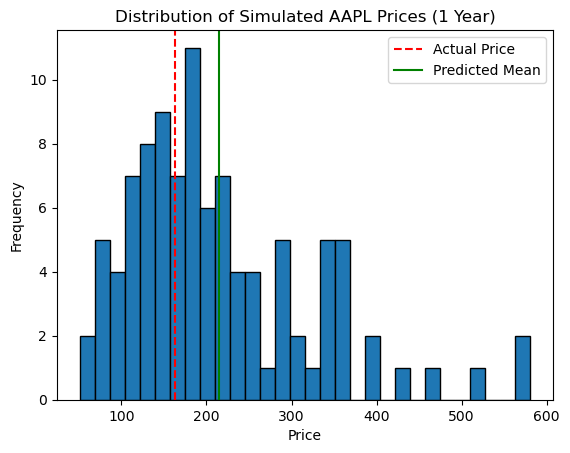

In [37]:
plt.hist(simulated_prices, bins=30, edgecolor='black')
plt.axvline(actual_price, color='red', linestyle='--', label='Actual Price')
plt.axvline(predicted_mean, color='green', linestyle='-', label='Predicted Mean')
plt.title("Distribution of Simulated AAPL Prices (1 Year)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("aapl_distribution.png", dpi=150) 
plt.show()

📊 AAPL
Mean: $218.32, Min: $49.27, Max: $529.27
Actual AAPL price on 2022-03-01: $163.20
Prediction error: 33.77%

📊 MSFT
Mean: $339.68, Min: $92.59, Max: $712.31
Actual MSFT price on 2022-03-01: $294.95
Prediction error: 15.16%

📊 GOOGL
Mean: $164.64, Min: $55.51, Max: $436.48
Actual GOOGL price on 2022-03-01: $134.06
Prediction error: 22.81%

📊 TSLA
Mean: $1420.47, Min: $165.86, Max: $10519.86
Actual TSLA price on 2022-03-01: $288.12
Prediction error: 393.01%

📊 META
Mean: $392.80, Min: $134.00, Max: $944.69
Actual META price on 2022-03-01: $203.49
Prediction error: 93.03%

📊 AMZN
Mean: $282.51, Min: $114.31, Max: $846.05
Actual AMZN price on 2022-03-01: $151.14
Prediction error: 86.91%

📊 DIS
Mean: $351.19, Min: $100.58, Max: $1109.22
Actual DIS price on 2022-03-01: $145.70
Prediction error: 141.04%

📊 PFE
Mean: $38.87, Min: $12.99, Max: $110.50
Actual PFE price on 2022-03-01: $45.75
Prediction error: 15.03%



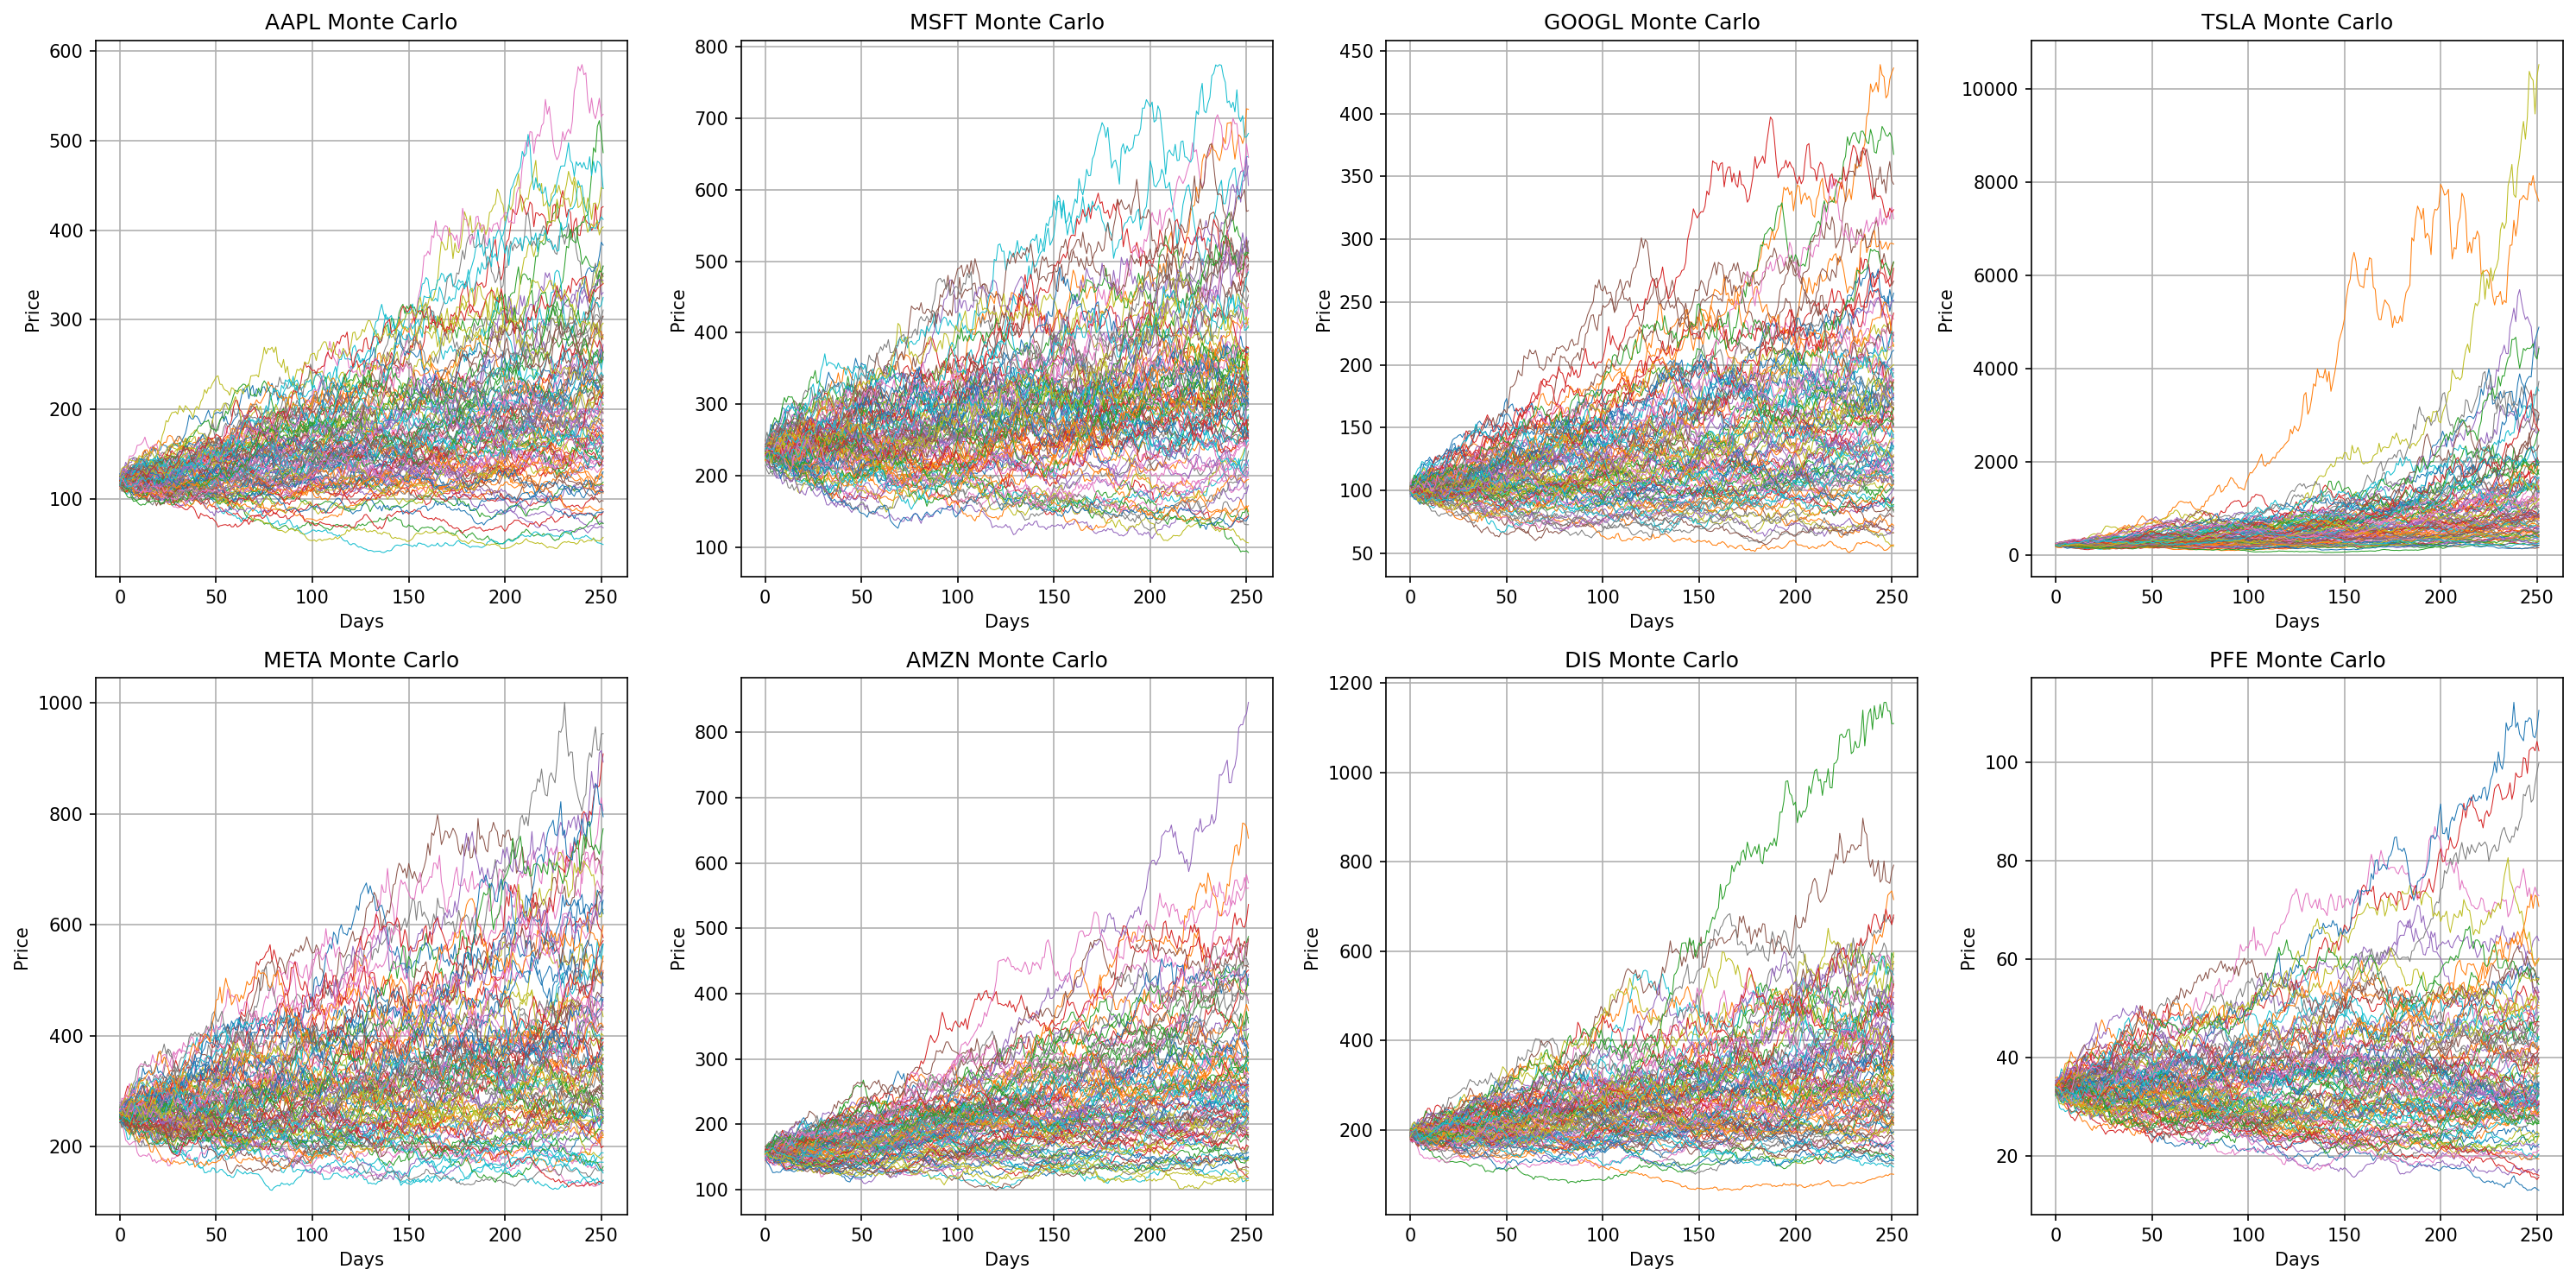

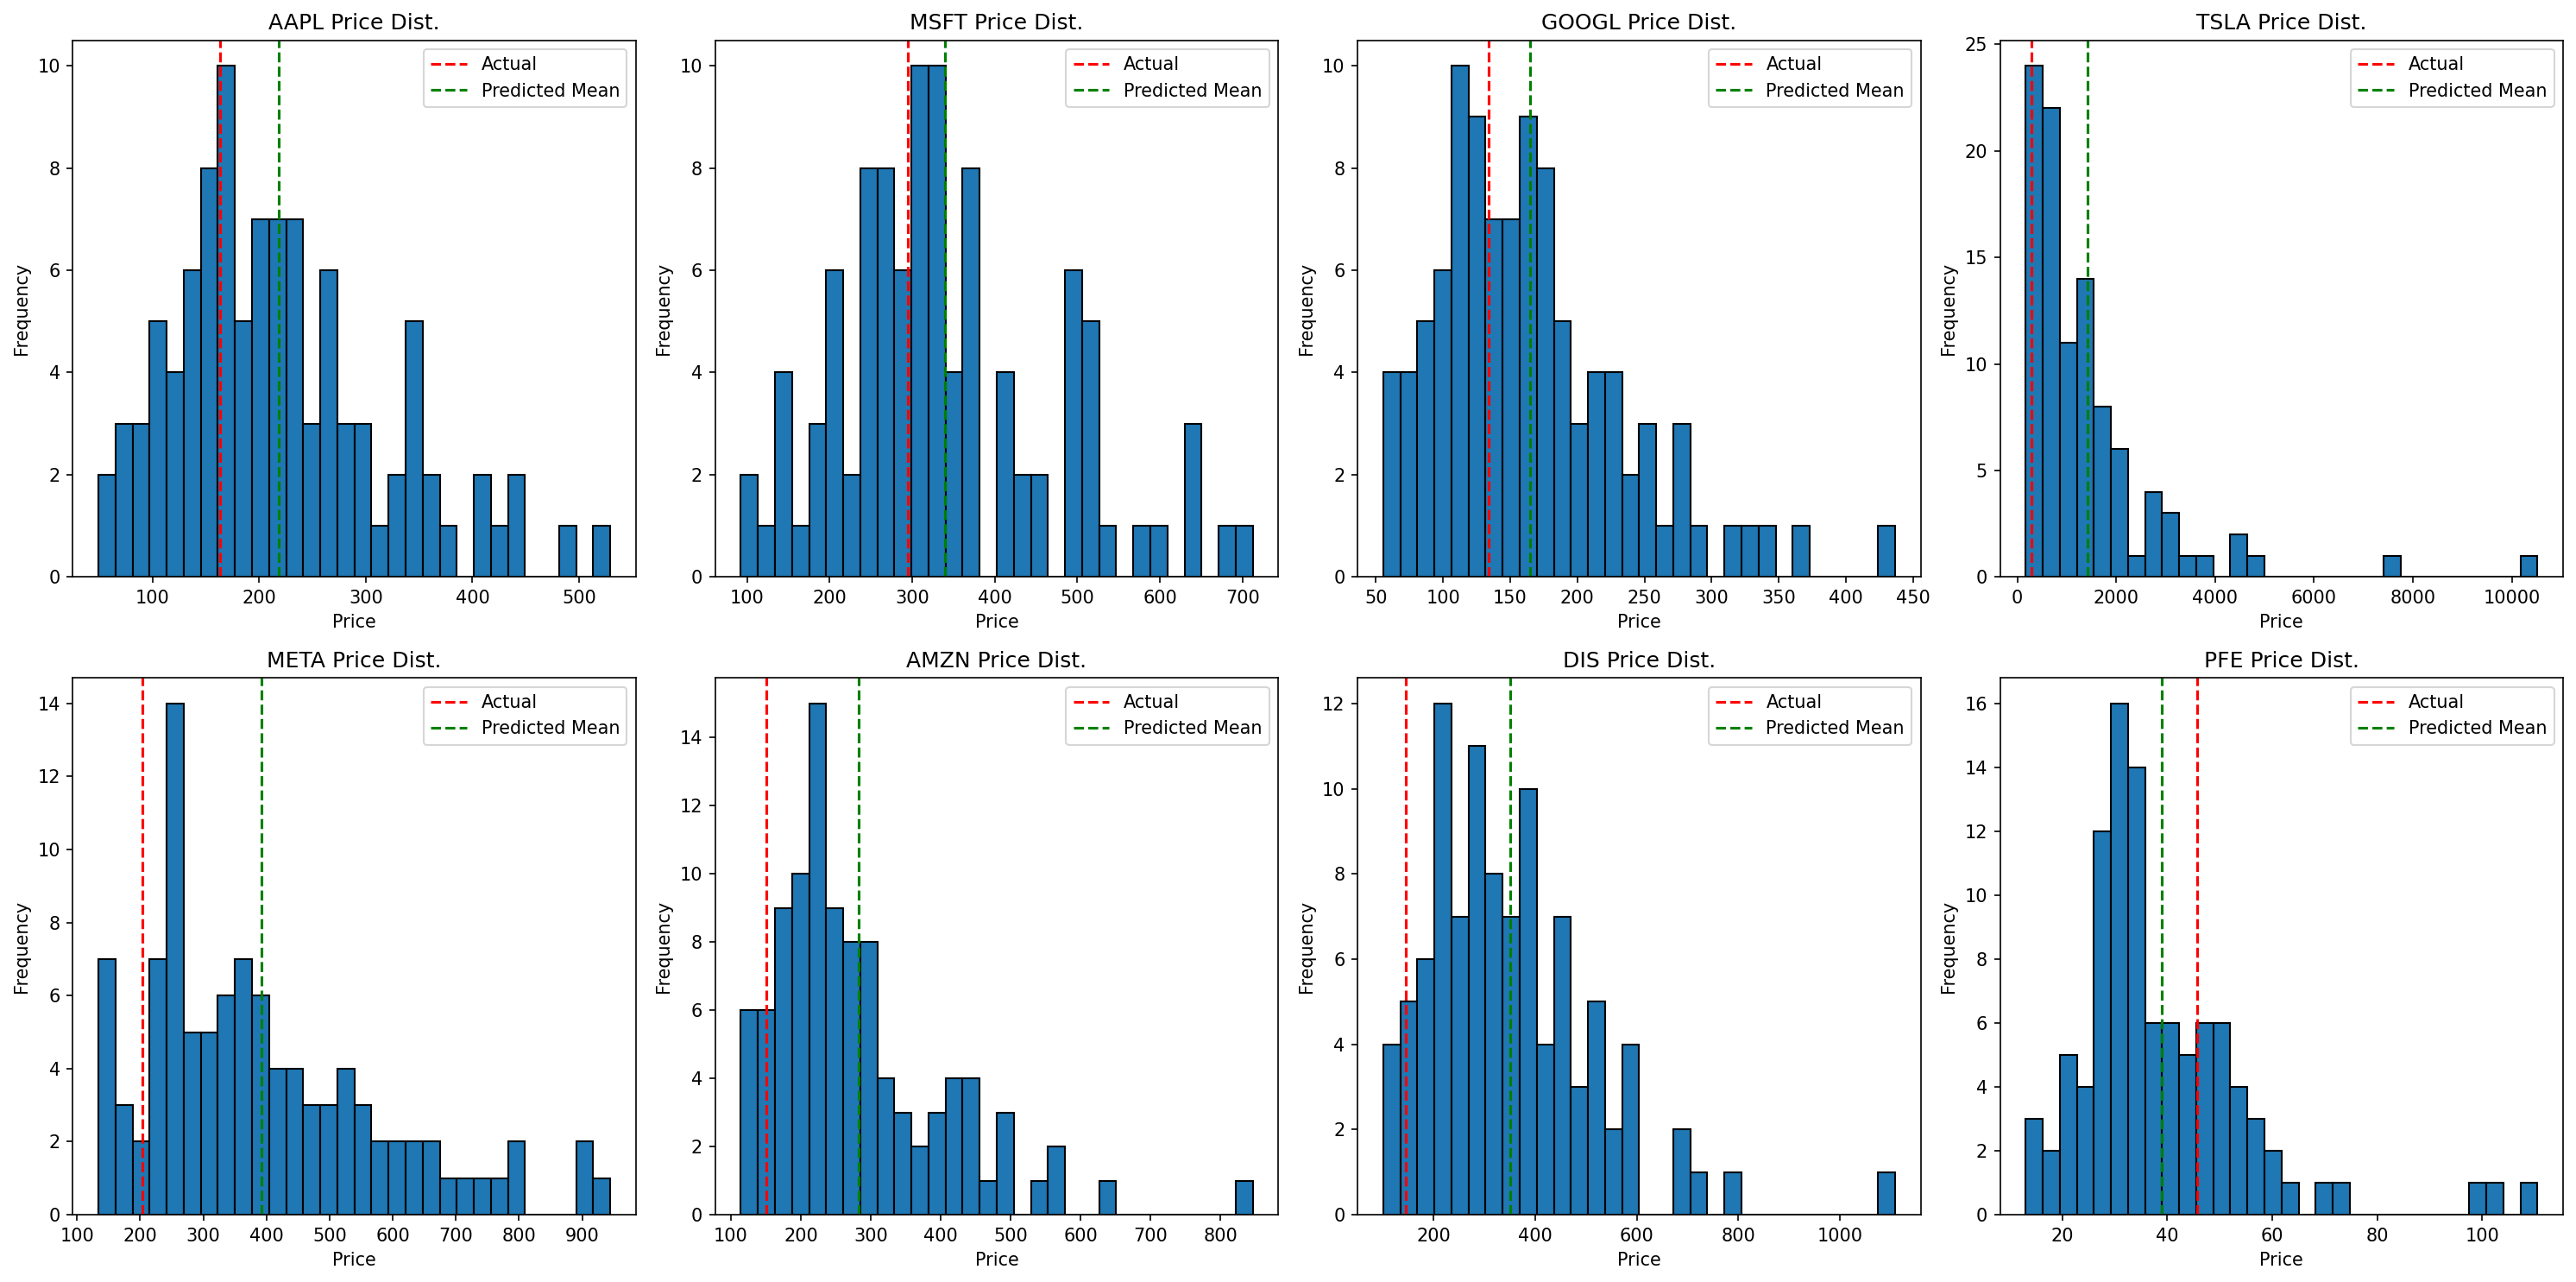

In [38]:
# Repeating the entire process for all stocks
simulations = 100
days = 252

fig_sim, axs_sim = plt.subplots(2, 4, figsize=(20, 10), dpi=150)
fig_dist, axs_dist = plt.subplots(2, 4, figsize=(20, 10), dpi=150)

for i, symbol in enumerate(stock_symbols):
    mu = mean_returns[symbol]
    sigma = volatility[symbol]
    last_price = price_data[symbol]["close"].iloc[-1]
    
    paths = np.zeros((days, simulations))
    for j in range(simulations):
        daily_sim_returns = np.random.normal(mu, sigma, days)
        paths[:, j] = last_price * np.cumprod(1 + daily_sim_returns)
    
    # Get final simulated prices
    simulated_prices = paths[-1]
    predicted_mean = simulated_prices.mean()
    predicted_min = simulated_prices.min()
    predicted_max = simulated_prices.max()
    
    # Get actual price from API or stored df
    actual_df = fetch_prices(symbol, "2022-02-28", "2022-03-02", key1)
    actual_price = actual_df.loc[actual_df["datetime"] == "2022-03-01", "close"].values[0]
    
    error_pct = abs(predicted_mean - actual_price) / actual_price * 100

    print(f"📊 {symbol}")
    print(f"Mean: ${predicted_mean:.2f}, Min: ${predicted_min:.2f}, Max: ${predicted_max:.2f}")
    print(f"Actual {symbol} price on 2022-03-01: ${actual_price:.2f}")
    print(f"Prediction error: {error_pct:.2f}%\n")
    
    # Plot simulations
    ax_sim = axs_sim[i // 4][i % 4]
    ax_sim.plot(paths, linewidth=0.5)
    ax_sim.set_title(f"{symbol} Monte Carlo")
    ax_sim.set_xlabel("Days")
    ax_sim.set_ylabel("Price")
    ax_sim.grid(True)

    # Plot distribution
    ax_dist = axs_dist[i // 4][i % 4]
    ax_dist.hist(simulated_prices, bins=30, edgecolor='black')
    ax_dist.axvline(actual_price, color='red', linestyle='--', label='Actual')
    ax_dist.axvline(predicted_mean, color='green', linestyle='--', label='Predicted Mean')
    ax_dist.set_title(f"{symbol} Price Dist.")
    ax_dist.set_xlabel("Price")
    ax_dist.set_ylabel("Frequency")
    ax_dist.legend()

fig_sim.tight_layout()
fig_sim.savefig("all_simulations.png")

fig_dist.tight_layout()
fig_dist.savefig("all_distributions.png")
plt.show()